<a href="https://colab.research.google.com/github/martin-fabbri/colab-notebooks/blob/master/deeplearning.ai/tf/c4_w1_time_series_baselines.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series & Prediction Baselines

The next code will set up the time series with seasonality, trend and a bit of noise.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras

In [2]:
def plot_series(times, series, format='-', start=0, end=None):
  # plt.figure(figsize=(10, 6))
  plt.plot(times[start:end], series[start:end], format)
  plt.xlabel('time')
  plt.ylabel('value')
  plt.grid(True)

def trend(time, slope=0):
  return slope * time

def seasonal_patten(season_time):
  '''
  Just an arbitrary pattern, you can change it if you wish
  '''
  return np.where(season_time < 0.4,
                  np.cos(season_time * 2 * np.pi),
                  1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
  '''
  Repeats the same patten at each period
  '''
  season_time = ((time + phase) % period) / period
  return amplitude * seasonal_patten(season_time)


def noise(time, noise_level=1, rnd=np.random.RandomState(42)):
  return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4 * 365 + 1, dtype='float32')
baseline = 10
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
rnd_seed = np.random.RandomState(42)
trend_series = trend(time, slope)
seasonality_series = seasonality(time, period=365, amplitude=amplitude)

series = baseline + trend_series + seasonality_series
series += noise(time, noise_level, rnd=rnd_seed)

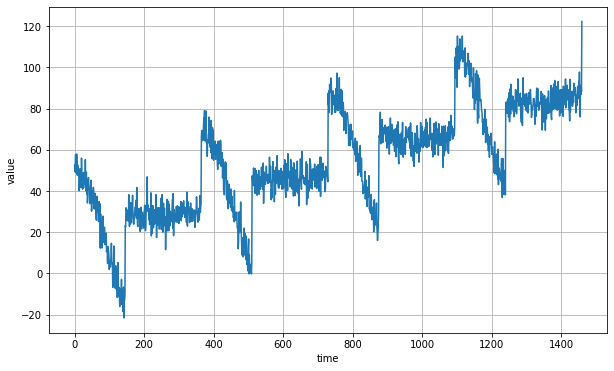

In [4]:
plt.figure(figsize=(10, 6));
plot_series(time, series);

Now that we have the time series, let's split it so we can start forecasting

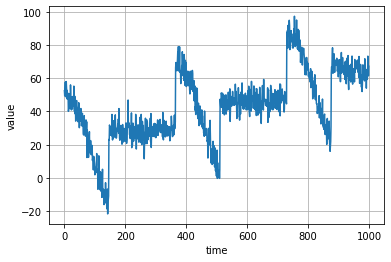

In [5]:
split_time = 1000

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

plt.plot(time_train, x_train);
plt.xlabel('time');
plt.ylabel('value');
plt.grid(True);

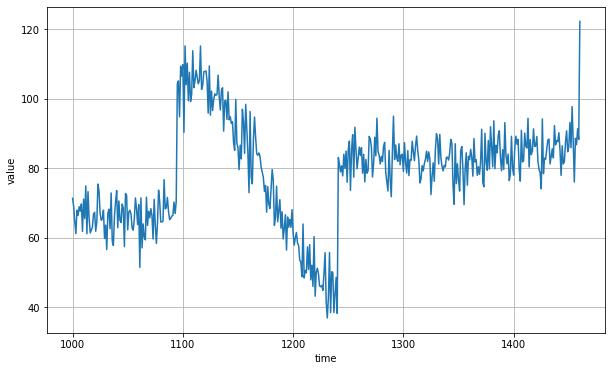

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(time_valid, x_valid);
plt.xlabel('time');
plt.ylabel('value');
plt.grid(True);

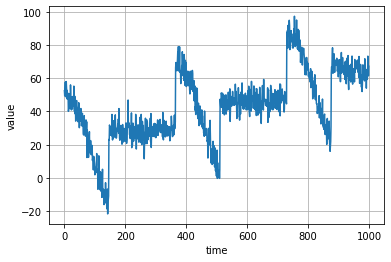

In [7]:
plot_series(time_train, x_train)

## Naive Forecast

In [8]:
naive_forecast = series[split_time - 1: -1]

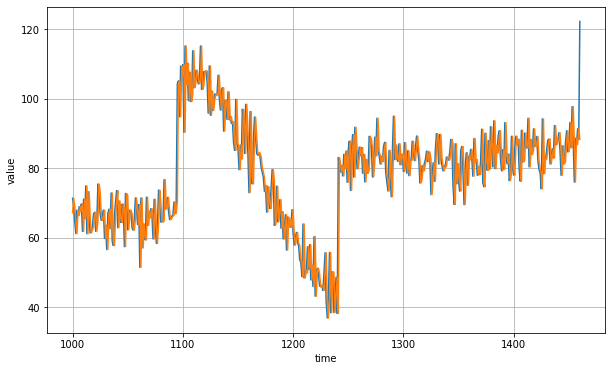

In [9]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

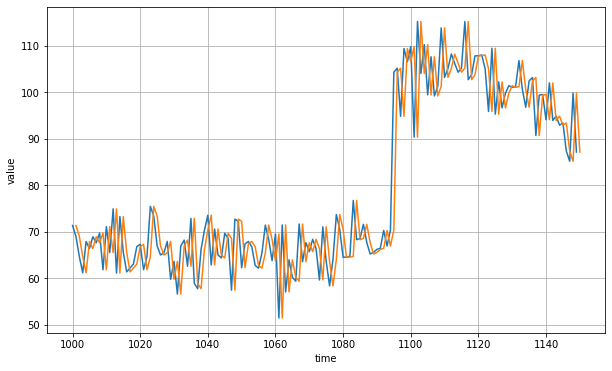

In [10]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean squared error and the mean absolute error between the forecast and the predictions in the validation period.

In [11]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

61.827534
5.937908


That's our baseline, now let's try a moving average:

In [12]:
def moving_average_forecast(series, window_size):
  '''
  Forecast the mean of the last few values.
  If window_size=1, then this is equivalent to the naive forecast
  '''
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return forecast

In [13]:
moving_average_forecast(np.arange(10), 5)

[2.0, 3.0, 4.0, 5.0, 6.0]

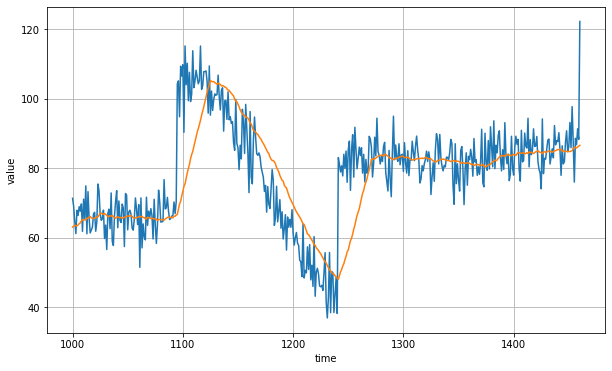

In [14]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [16]:
print('naive forecast mse:')
print('')
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())
print('')
print('-----')
print('')
print('moving average:')
print('')
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

naive forecast mse:

61.827534
5.937908

-----

moving average:

106.674576
7.1424184


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will substract the value at time $t - 365$ from the value at time t.

In [28]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

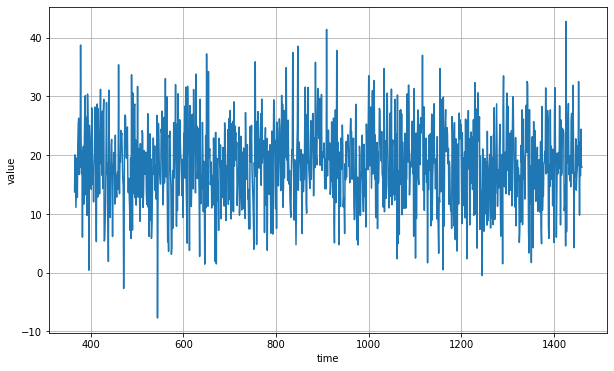

In [29]:
plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

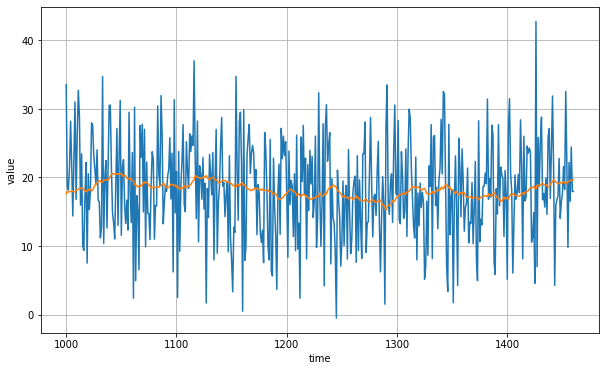

In [31]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]
plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)

Now let's bring back the trend and seasonality by adding the past values from $t - 365$

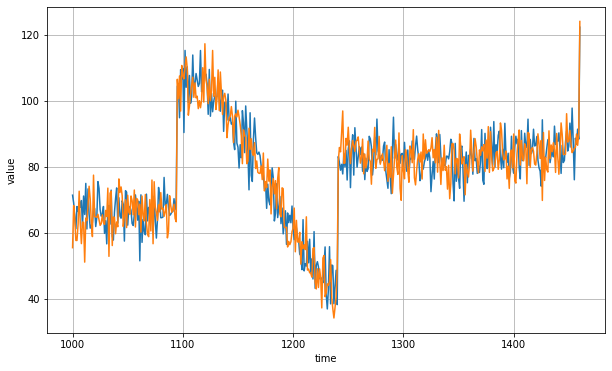

In [33]:
diff_moving_avg_plus_past = series[split_time - 365: -365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)

In [34]:
print('naive forecast mse:')
print('')
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())
print('')
print('-----')
print('')
print('Diff moving average plus past:')
print('')
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

naive forecast mse:

61.827534
5.937908

-----

Diff moving average plus past:

52.97366
5.839311


Better than naive forecast, good. However the forecast look a bit too random, because we're just adding past values, which were noise. Let's use a moving averaging on past values to remove some of the noise:

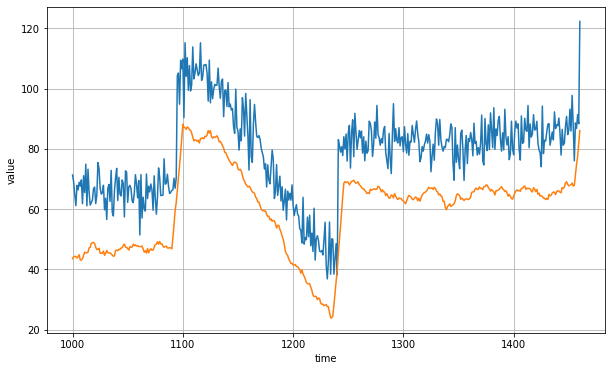

In [48]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

diff_moving_avg_plus_smooth_past = diff_moving_avg_plus_smooth_past[:time_valid.shape[0]]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)